# EMILIO FRAUSTO ORTIZ

## IMPORTAR TODAS LAS LIBRERIAS 

In [1]:
import xml.etree.ElementTree as ET
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
import nltk
import os
import numpy as np
from collections import Counter
from nltk.tokenize import TweetTokenizer
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.manifold import TSNE
from matplotlib import patheffects
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

## PRUEBAS BASICAS

In [2]:
#Este es un ejemplo basico para comprender como leer los xml

# 1. Parsear archivo
tree = ET.parse("author_profiling_pan/es_train/100f11229a97c38f95e0a563039af29e.xml")
root = tree.getroot()

# Si root es directamente <author>
docs = [doc.text for doc in root.find("documents").findall("document")]
texto_autor = " ".join(docs)
print(texto_autor[:300],'Y MAS')



¿Os habéis perdido el directo de hoy? ¡Puedes verlo ahora! https://t.co/8BUWSZJ8zZ ¡Muchas gracias por ver mi vídeo de hoy en directo en YouTube! Empecemos bien la semana ;) Let's… https://t.co/NqR95v82ON En 5 minutos comienzo a emitir en directo https://t.co/8BUWSZrxIr ¡Acompáñame! RT!! DIRECTO: ¿Q Y MAS


## LECTURA DE DATOS

In [3]:
etiquetas = {}
with open("author_profiling_pan/es_train/truth.txt", encoding="utf8") as f:
    for linea in f:
        partes = linea.strip().split(":::")
        autor_id, genero, pais = partes
        etiquetas[autor_id] = pais   # para tu tarea solo importa el país


In [4]:

tokenizer = TweetTokenizer()


In [5]:

def lectura_xml(ruta):
    #INICIALIZAR LISTAS VACIAS
    # X = A TODOS LOS TUITS POR AUTOR EJ: El primer codigo, como si leyera el archivo 100f11229a97c38f95e0a563039af29e.xml
    # Y = AL IDIOMA DEL AUTOR         EJ: Colombia
    X, y = [], []
    for archivo in os.listdir(ruta):
        if archivo.endswith(".xml"):
            autor_id = archivo.replace(".xml","")
            if autor_id in etiquetas:
                tree = ET.parse(os.path.join(ruta, archivo))
                root = tree.getroot()
                
                # Concatenar TODOS los tuits de ese autor
                docs = [doc.text for doc in root.find("documents").findall("document")]
                texto_autor = " ".join(docs)
                
                X.append(texto_autor)
                y.append(etiquetas[autor_id])  # nacionalidad del autor

    return X, y


In [6]:
ruta = "author_profiling_pan/es_train"
tuits_autor , nacionalidad_autor = lectura_xml(ruta)
print(tuits_autor[0][:100],'\n =========================Este es el primer autor que tenemos')
print(nacionalidad_autor[0],'\n =========================Y esta es su nacionalidad')

¿Os habéis perdido el directo de hoy? ¡Puedes verlo ahora! https://t.co/8BUWSZJ8zZ ¡Muchas gracias p 
 =========================Este es el primer autor que tenemos
spain 
 =========================Y esta es su nacionalidad


Text(0.5, 0, 'Nacionalidades')

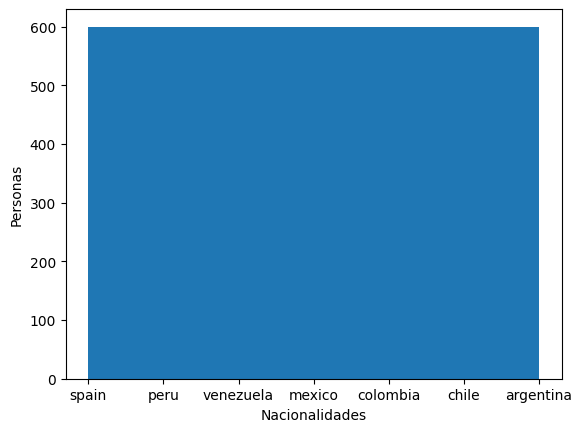

In [7]:
plt.hist(nacionalidad_autor,bins=len(set(nacionalidad_autor)))
plt.ylabel('Personas')
plt.xlabel('Nacionalidades')

In [8]:
print(len(tuits_autor),len(nacionalidad_autor))

4200 4200


## PREPARACION Y CREACION DE BOLSA DE PALABRAS BIANRIA

In [9]:

def sortFreqDist(freqdist):
    aux = [(freqdist[key], key) for key in freqdist]
    aux.sort()
    aux.reverse()
    return aux


In [10]:
def build_bowl_tr_bin(tr_txt, vocabulary, dict_indices):
    # El objetivo es construir la matriz BOW
    bowl = np.zeros((len(tr_txt), len(vocabulary)), dtype=int) #Matriz de BOWL

    # RELLENAR LA MATRIZ BOWL, cada renglon es un tuit y cada columna una palabra
    #Si la palabra aparece en el tuit, poner un uno
    count_doc = 0
    for tuit in tr_txt:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tuit.lower())) #Tuit tokenizado
        for word in fdist_doc:
            if word in dict_indices:
                bowl[count_doc, dict_indices[word]] = 1 #rellenar
        count_doc += 1
    
    return bowl

In [11]:

todas_palabras = []

for twuit in tuits_autor:
    todas_palabras += tokenizer.tokenize(twuit)


In [12]:
f_dic = nltk.FreqDist(todas_palabras)


In [13]:
vocabulario_con_frecuencia = sortFreqDist(f_dic)

print(vocabulario_con_frecuencia[:100])

[(207499, 'de'), (161954, ','), (157420, '.'), (135543, 'que'), (117553, 'la'), (109055, '!'), (105272, 'y'), (102529, 'a'), (96429, 'en'), (93004, 'el'), (68701, 'no'), (53756, 'es'), (53439, '?'), (47446, 'los'), (46736, '...'), (46478, 'un'), (43086, 'con'), (42105, 'se'), (41856, 'por'), (39749, '"'), (39570, 'me'), (38665, 'lo'), (38018, 'para'), (31447, 'del'), (28813, ':'), (28079, 'las'), (27223, 'una'), (24411, '…'), (21642, 'mi'), (21532, 'te'), (20089, 'al'), (19607, 'más'), (17795, 'como'), (17107, 'El'), (16726, 'si'), (16537, 'q'), (16298, 'pero'), (16080, '-'), (15589, '('), (15557, 'No'), (15474, 'La'), (15283, 'su'), (15097, '😂'), (13787, 'ya'), (13772, ')'), (13411, 'Y'), (12745, '¿'), (12589, 'le'), (12283, 'Que'), (12145, 'todo'), (11435, 'tu'), (11333, 'Me'), (11049, 'vía'), (10672, 'yo'), (10002, 'o'), (9986, 'esta'), (9756, 'este'), (9601, '¡'), (9165, 'hay'), (9109, 'son'), (9095, 'ser'), (8947, 'cuando'), (8808, 'está'), (8557, 'A'), (8510, 'mejor'), (8483, '😍'

In [14]:
#Asegurar un orden en el diccionario
dict_indices = dict()

cont = 0
for weight, word in vocabulario_con_frecuencia:
    dict_indices[word] = cont
    cont += 1

In [15]:
bolsa_binaria = build_bowl_tr_bin(tuits_autor, vocabulario_con_frecuencia , dict_indices)

In [16]:
#( tuits , palabras )
bolsa_binaria.shape

(4200, 499662)

## BOLSA DE PALABRAS CON FRECUENCIA (DOR)

In [17]:
def build_bowl_tr(tr_txt, vocabulary, dict_indices):
    # El objetivo es construir la matriz BOW
    bowl = np.zeros((len(tr_txt), len(vocabulary)), dtype=int) #Matriz de BOWL

    # RELLENAR LA MATRIZ BOWL, cada renglon es un tuit y cada columna una palabra
    #Si la palabra aparece en el tuit, poner un uno
    count_doc = 0
    for tuit in tr_txt:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tuit.lower())) #Tuit tokenizado
        for word in fdist_doc:
            if word in dict_indices:
                bowl[count_doc, dict_indices[word]] = fdist_doc[word] 
        count_doc += 1
    
    return bowl

In [18]:
def compute_dor(bolsa):
    # SE MODIFICO UN POCO LA MATRIZ PARA QUE FUERA MAS LIGERA Y PODER CREARLA SIN LIMITARSE
    dim = bolsa.shape
    dor = np.zeros((dim[0],dim[1]), dtype=np.float32)

    tam_v = dim[1] 
    
    for doc, i in zip(bolsa, range(len(bolsa))):
        non_zero_positions = np.nonzero(doc)[0] #las dimensiones de las palabras contenidas en el tuit
        tam_v_tuit = len(non_zero_positions)
        for term in non_zero_positions:
            dor[i,term] = np.log(1 + doc[term]) * np.log(tam_v/tam_v_tuit)
    
    return dor
        

In [19]:
# SE NECESITA DISMINUIR EL TAMAÑO DEL VOCABULARIO 
Tweet_tokenizer = TweetTokenizer()
contador = Counter()

for texto in tuits_autor:
    tokens = Tweet_tokenizer.tokenize(texto)   # tu función de tokenización
    contador.update(tokens)

top_n = 20000
vocabulario_disminuido = [palabra for palabra, _ in contador.most_common(top_n)]
dict_indices = {palabra: idx for idx, palabra in enumerate(vocabulario_disminuido)}

In [20]:
bolsa_frecuencia = build_bowl_tr(tuits_autor,vocabulario_disminuido , dict_indices)

In [21]:
bolsa_frecuencia

array([[ 54,  34,  14, ...,   0,   0,   0],
       [ 30,  21,   3, ...,   0,   0,   0],
       [ 70,  48,  75, ...,   0,   0,   0],
       ...,
       [ 64,  11,   0, ...,   0,   0,   0],
       [ 83,  67,  25, ...,   0,   0,   0],
       [ 53,  52, 107, ...,   0,   0,   0]])

In [22]:
bolsa_binaria_disminuida = build_bowl_tr_bin(tuits_autor, vocabulario_disminuido, dict_indices)

In [23]:
dor = compute_dor(bolsa_binaria)

In [24]:
dor

array([[4.79319  , 4.79319  , 4.79319  , ..., 0.       , 0.       ,
        0.       ],
       [4.824637 , 4.824637 , 4.824637 , ..., 0.       , 0.       ,
        0.       ],
       [4.7317147, 4.7317147, 4.7317147, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [4.700458 , 4.700458 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [4.643005 , 4.643005 , 4.643005 , ..., 0.       , 0.       ,
        0.       ],
       [4.576532 , 4.576532 , 4.576532 , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

## NORMALIZACION

In [25]:
dor_normalizado = preprocessing.normalize(dor, norm='l2')
print(dor_normalizado.shape)

(4200, 499662)


In [26]:
feature_selector = SelectKBest(chi2, k=1000)

#selecciona palabras importantes
feature_selector.fit(bolsa_binaria_disminuida, nacionalidad_autor)

SelectKBest(k=1000, score_func=<function chi2 at 0x00000295875E0360>)

In [27]:
best = feature_selector.get_support(indices=True)

In [28]:
dict_indices_invertido = {valor: key for key, valor in dict_indices.items()}

In [29]:
t_words = [dict_indices_invertido[index] for index in best]

In [30]:
target_matrix = np.array([dor_normalizado[:,dict_indices[word]] for word in t_words])

In [31]:
target_matrix.shape

(1000, 4200)

In [32]:
dor_normalizado.shape

(4200, 499662)

## REDUCCION DE DIMENSION

In [33]:
matriz_reducida = TSNE(n_components = 2).fit_transform(target_matrix)

In [34]:
max_x , max_y = np.max(matriz_reducida, axis=0)
min_x , min_y = np.min(matriz_reducida, axis=0)

print(f"max_x: {max_x}, max_y: {max_y}")
print(f"min_x: {min_x}, min_y: {min_y}")

max_x: 43.845672607421875, max_y: 58.28349304199219
min_x: -61.24179458618164, min_y: -58.817054748535156


C:\Users\efrau\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127926 (\N{MULTIPLE MUSICAL NOTES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\efrau\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128149 (\N{TWO HEARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\efrau\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\efrau\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\efrau\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\py

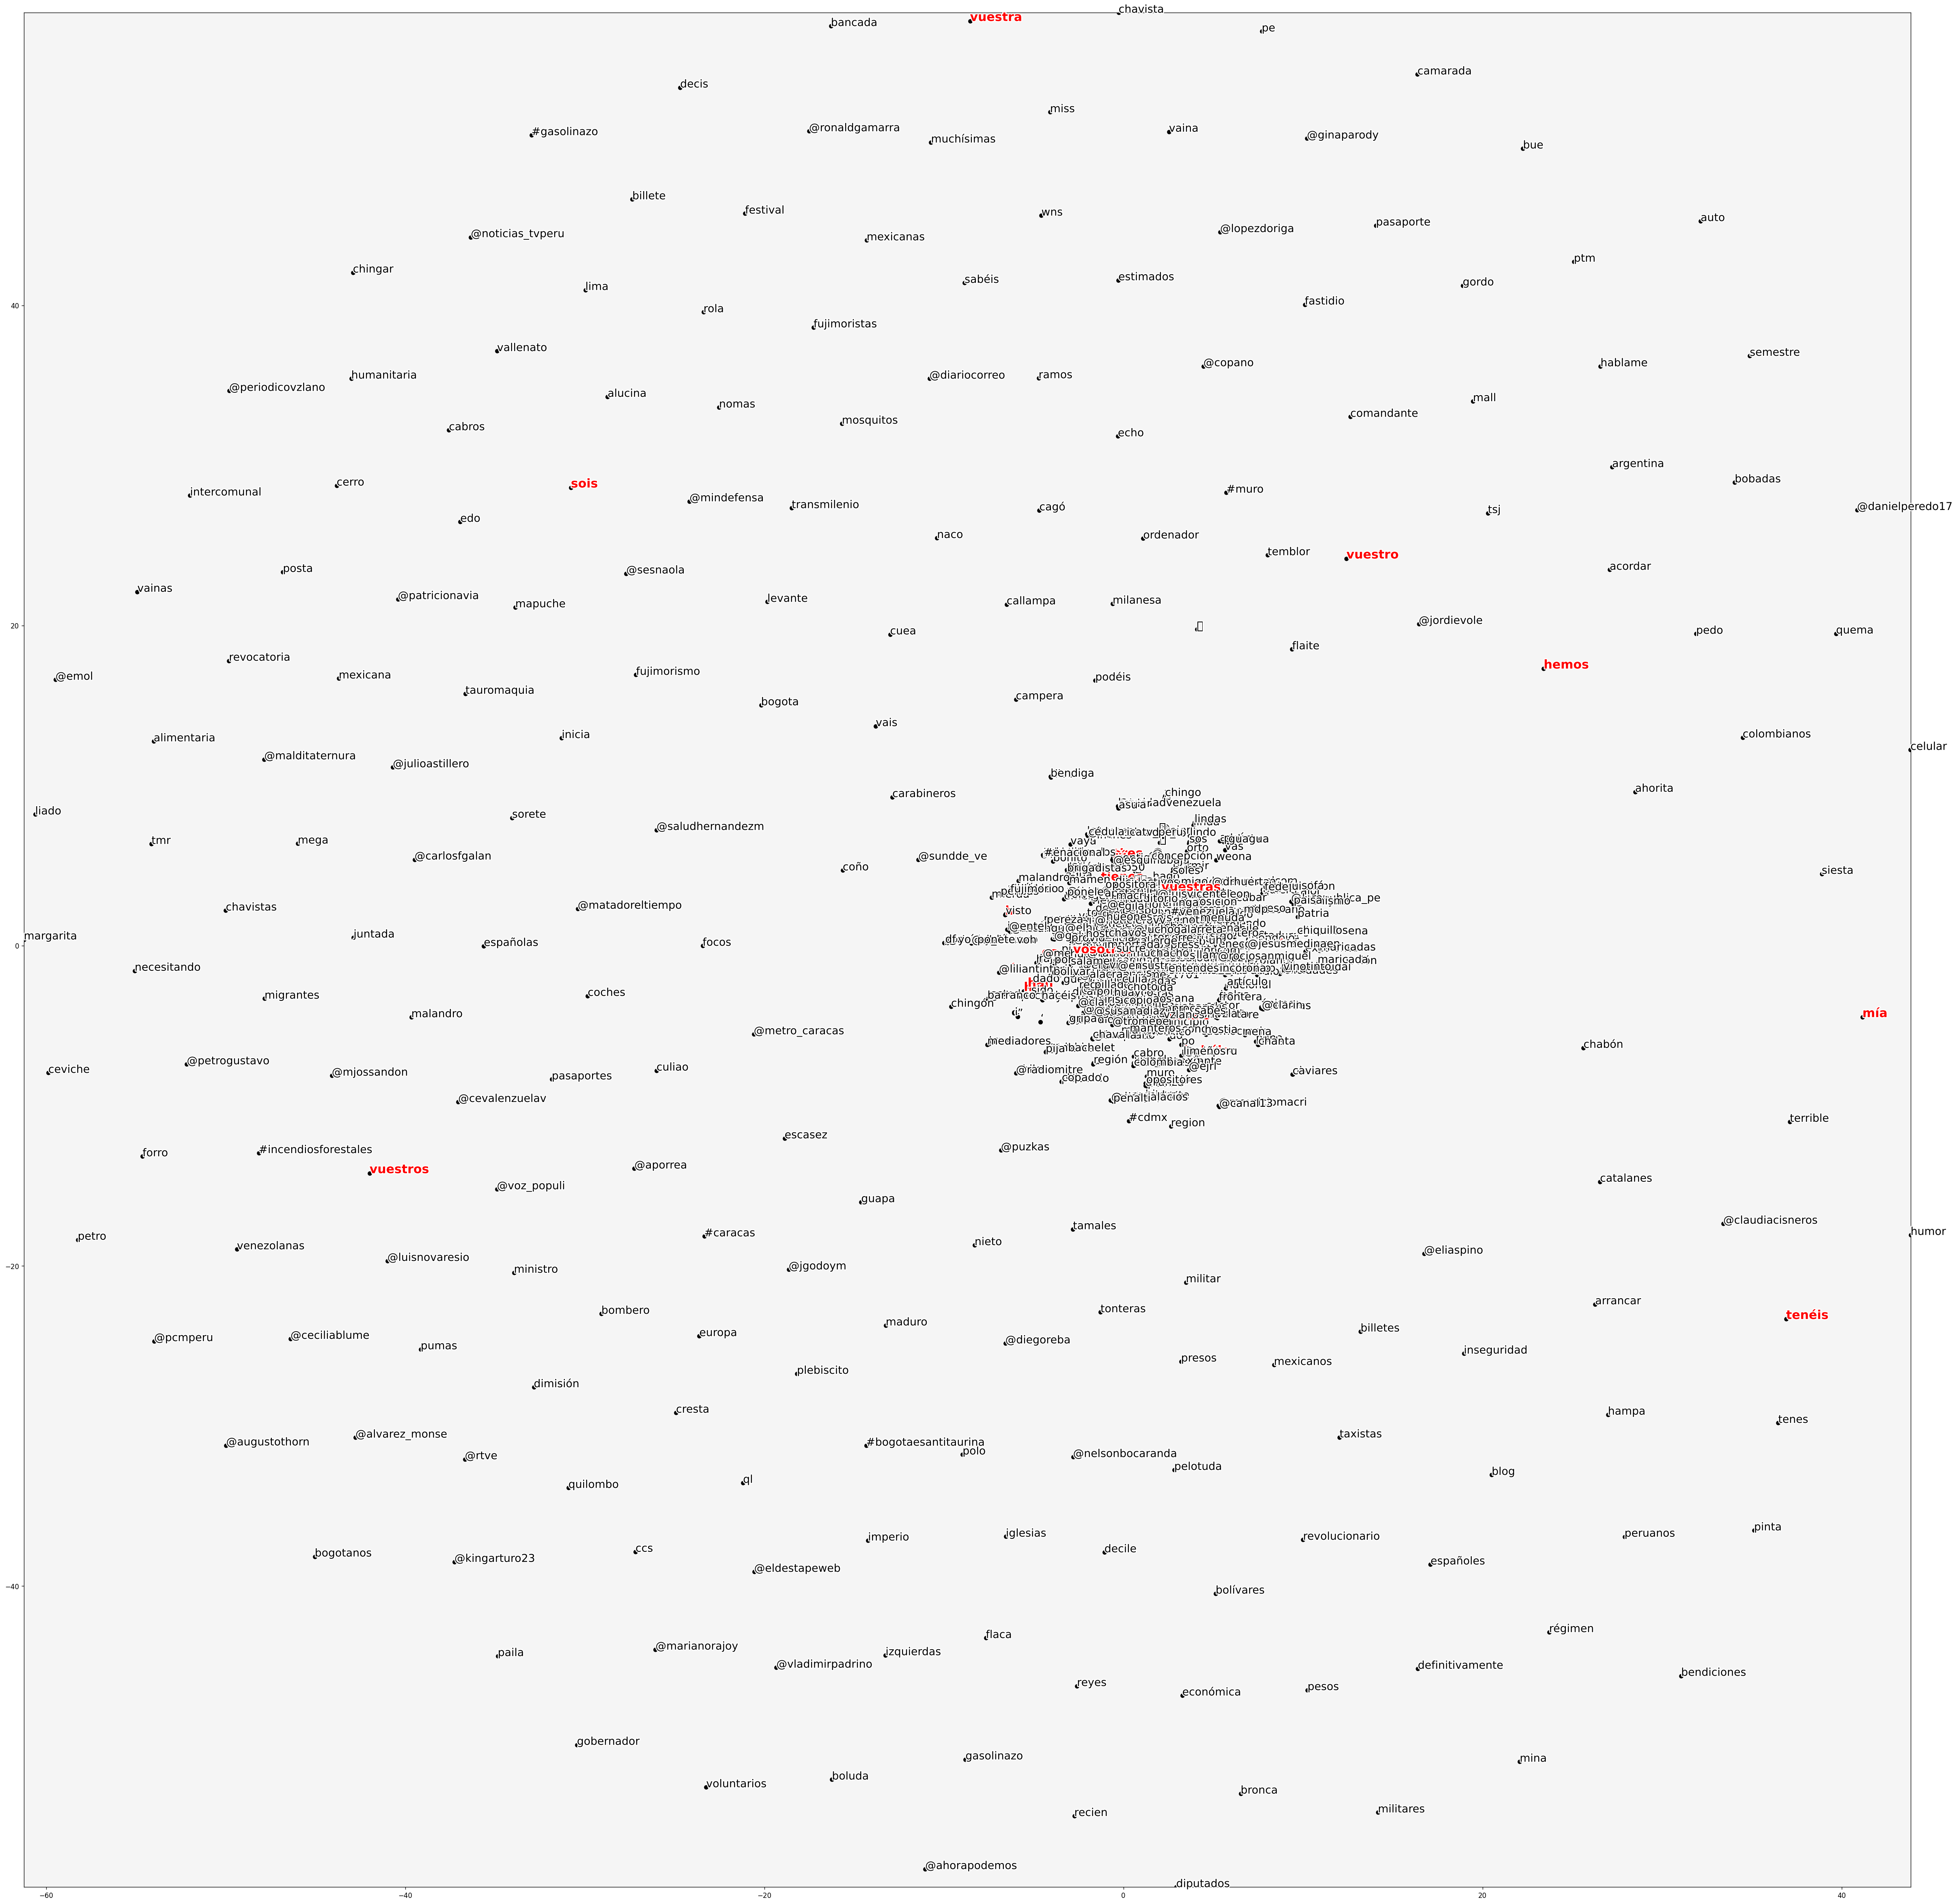

In [35]:

x, y = matriz_reducida[:, 0], matriz_reducida[:, 1]

plt.figure(figsize=(50, 50), dpi=120)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.scatter(x, y, s=30, color='black')






sw = stopwords.words('spanish')


for i, word in enumerate(t_words):
    if word in sw:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=18, 
            color='red', 
            fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )
    elif word in ['valer']:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=22, 
            color='blue', 
            fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )
    else:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=16, 
            color='black',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )

plt.gca().set_facecolor('whitesmoke')
plt.show()

In [36]:
from sklearn.model_selection import train_test_split
X = dor_normalizado            # o tu BoW por tuit
y = np.array(nacionalidad_autor)

print("X.shape:", X.shape)     # debería ser (4200, d)
print("len(y):", len(y))       # debería ser 4200

assert X.shape[0] == len(y), f"Desajuste: X={X.shape[0]}, y={len(y)}"

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,          # ← usa el MISMO objeto y
    random_state=42
)


X.shape: (4200, 499662)
len(y): 4200


## EVALUAR

In [37]:


def evaluar_SVM(X, y, nombre):
    from sklearn.model_selection import train_test_split
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    clf = LinearSVC(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="macro")
    
    print(f"{nombre} → Accuracy: {acc:.3f}, F1-macro: {f1:.3f}")
    return nombre, acc, f1
    


In [38]:
resultados = []
resultados.append(evaluar_SVM(bolsa_binaria_disminuida, nacionalidad_autor, "BoW binaria"))
resultados.append(evaluar_SVM(bolsa_frecuencia, nacionalidad_autor, "BoW frecuencia"))
resultados.append(evaluar_SVM(preprocessing.normalize(bolsa_binaria_disminuida, norm="l2"), nacionalidad_autor, "BoW binaria + L2"))
resultados.append(evaluar_SVM(preprocessing.normalize(bolsa_frecuencia, norm="l2"), nacionalidad_autor, "BoW frecuencia + L2"))


BoW binaria → Accuracy: 0.918, F1-macro: 0.918


C:\Users\efrau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


BoW frecuencia → Accuracy: 0.880, F1-macro: 0.880
BoW binaria + L2 → Accuracy: 0.937, F1-macro: 0.937
BoW frecuencia + L2 → Accuracy: 0.854, F1-macro: 0.853


In [39]:

df_resultados = pd.DataFrame(resultados, columns=["Experimento", "Accuracy", "F1"])
print(df_resultados)


           Experimento  Accuracy        F1
0          BoW binaria  0.917857  0.918192
1       BoW frecuencia  0.879762  0.879876
2     BoW binaria + L2  0.936905  0.937135
3  BoW frecuencia + L2  0.853571  0.852756


## Conclusiones + comentarios

**Tiene mucho sentido que los resultados del BoW bianrio sean los mejores ya que los procesaria como un matriz bianria de ausencia/presencia de nacionalidades en el tuit. Lo que mas le ayuda al BoW binario es la ausencia de las otras nacionalidades, mas que cuantas veces aparecio la misma nacionalidad, esto elimina mucho ruido en los tuits. Lo que pasa con el BoW de frecuencia es que a veces le da demaisada importancia a palabras que se repiten mucho, pero eso no signifca que vayan a ser importantes para averiguar de donde son.**

Un aspecto importante en este tipo de tareas es tener muy claro qué es lo que realmente se va a predecir. Al inicio pensé que se debía predecir la nacionalidad a nivel de tuit, pero en el dataset las etiquetas (truth) están definidas por autor, no por mensaje individual. Una posible solución hubiera sido asignar la nacionalidad de cada autor a todos sus tuits, pero eso duplicaría las etiquetas y haría mucho más pesadas las matrices de representación. En cambio, trabajar a nivel de autor reduce el tamaño y se ajusta a cómo fue diseñado el dataset de author profiling. 